In [195]:
# Step 1 — ML Baseline: Logistic Regression + TF-IDF

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#  NLP libraries: spaCy
import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])


In [196]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     - ------------------------------------- 0.5/12.8 MB 430.4 kB/s eta 0:00:29
     - ------------------------------------- 0.5/12.8 MB 430.4 kB/s eta 0:00:29
     - ------------------------------------- 0.5/12.8 MB 430.4 kB/s eta 0:00:29
     - ------------------------------------- 0.5/12.8 MB 430.4 kB/s eta 0:00:29
     - ------------------------------------- 0.5/12.8 MB 430.4 kB/s eta 0:00:29
     - ------------------------------------- 0.5/12.8 MB 430.4 kB/s eta 0:00:29
     - ------------------------------------- 0.5/12.8 MB 430.4 kB/s eta 0:00:29
     -- 

In [197]:
#display 3 full sample reviews per rating
for rating in sorted(df['Rating'].unique()):
    print(f"\n⭐ Rating {rating}")
    reviews = df[df['Rating'] == rating].tail(3)
    for _, row in reviews.iterrows():
        print(f"\n- {row['review_text']}\n")


⭐ Rating 1

- i ended up throwing this stuff out it tasted that bad imagine blending grass in a blender until it is liquid and drinking it that is what this stuff tastes like


- with the increased popularity of argon and coconut oils being used by women of all ethnicities i mistakenly thought this product would be appropriate for my hair i use argon oil now and it really helps to calm frizz and flyaways for my colored and overly dry hairi have thick coarse wavy hair that is color treated i have used hot oils and leave in oils for years without having any problems but this product seems to be intended mostly for ethnic hair no where on the product does it say this but the advertisement has an ethnic model and other products in the line are clearly not intended for caucasian hairsince there are no directions on this product i would imagine i would use it the same way i use my argon oil but that results is limp greasy looking hair even when using the product sparingly and the ingredient

In [198]:
df['word_count'] = df['review_text'].apply(lambda x: len(str(x).split()))

In [199]:
#Ensure review_text is a string
df['review_text'] = df['review_text'].astype(str)

In [200]:
#display the statistics of the word count
min_word_counts = df.groupby('Rating')['word_count'].describe()
print(min_word_counts)

          count       mean        std   min   25%   50%    75%    max
Rating                                                               
1       12592.0  78.221410  62.892217  10.0  36.0  60.0   98.0  496.0
2       20719.0  85.786283  67.254613   6.0  39.0  66.0  109.0  499.0
3       29648.0  91.219172  73.110825   5.0  40.0  69.0  118.0  500.0
4       37775.0  86.504911  71.642348   5.0  37.0  64.0  111.0  499.0
5       25184.0  70.599825  59.891781   5.0  31.0  52.0   87.0  496.0


In [201]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df['review_text'],
    df['Rating'],
    test_size=0.2,
    random_state=42,
    stratify=df['Rating']  # keeps class distribution
)

In [202]:
# Words to keep (do NOT remove)
words_to_keep = {
    'not', 'no', 'never', 'none', 'nor', 'neither', "n't", "n‘t", "n’t",
    'but', 'although', 'though', 'however', 'unless', 'whereas', 'yet', 'still',
    'very', 'too', 'quite', 'rather', 'really', 'somewhat', 'much',
    'i', 'we', 'you', 'my', 'our', 'me', 'us', 'your', 'yours',
    'always','amount','almost','anyone','can','cannot','could','did','do','enough',
    'except','should','may','might','so','some','most','more','mostly'
}

for w in words_to_keep:
    if w in nlp.Defaults.stop_words:
        nlp.Defaults.stop_words.remove(w)
        nlp.vocab[w].is_stop = False


def spacy_preprocess_pipe(texts):
    processed = []
    for doc in nlp.pipe(texts, batch_size=1000, disable=["ner", "parser"]):  # disable unneeded parts
        tokens = [
            token.lemma_
            for token in doc
            if not token.is_stop and not token.is_space and token.is_alpha
        ]
        processed.append(" ".join(tokens))
    return processed

In [203]:
#print the list of stopwords
print(sorted(nlp.Defaults.stop_words))
# Print total number of unique stopwords in spaCy's English model
print("Number of spaCy stopwords:", len(nlp.Defaults.stop_words))

["'d", "'ll", "'m", "'re", "'s", "'ve", 'a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'alone', 'along', 'already', 'also', 'am', 'among', 'amongst', 'an', 'and', 'another', 'any', 'anyhow', 'anything', 'anyway', 'anywhere', 'are', 'around', 'as', 'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'both', 'bottom', 'by', 'ca', 'call', 'does', 'doing', 'done', 'down', 'due', 'during', 'each', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'few', 'fifteen', 'fifty', 'first', 'five', 'for', 'former', 'formerly', 'forty', 'four', 'from', 'front', 'full', 'further', 'get', 'give', 'go', 'had', 'has', 'have', 'he', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', 'hereupon', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'hundred', 'if', 'in', 'i

In [204]:
X_train = pd.Series(spacy_preprocess_pipe(X_train))
X_test = pd.Series(spacy_preprocess_pipe(X_test))

In [205]:
#shows the stopword removal and lemmatized text
print(X_train.sample(5).values)

['our animal shelter toy big favorite shiny colorful lightweight make crinkling sound crush bat I star except fact toy get bat water dish dye toy leak water discolor water cat not drink water anymore I not sure dye toxic not so I m glad cat do not drink iti not recommend toy cat confine small space open water dish but great item'
 'some historyour dog not chew rawhide bone habit break piece swallow we problem blockage constipation result everytime receive rawhidewe yr old beagle introduce greenie yr ago we give couple large one friend try carelessness our our dog destroy large treat minute we find we scare figure die swallow large plasticky look treat we quickly do some web search find new formula suppose dissolve rather easily water make sure drink good amount water we monitor activity end no problem we able find treat more chewable your biscuit type treat but safe rawhide we try different treat toy but never type response we give greenie seriously like crack dog'
 'awesome baby food 

In [206]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [207]:
#train using Logistic Regression
lr = LogisticRegression(max_iter=300, class_weight='balanced', solver='saga')
lr.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight='balanced', max_iter=300, solver='saga')


Classification Report:

              precision    recall  f1-score   support

           1     0.4477    0.6096    0.5162      2518
           2     0.4142    0.4148    0.4145      4144
           3     0.4739    0.4293    0.4505      5930
           4     0.5766    0.4712    0.5186      7555
           5     0.5718    0.6877    0.6244      5037

    accuracy                         0.5092     25184
   macro avg     0.4968    0.5225    0.5049     25184
weighted avg     0.5118    0.5092    0.5064     25184



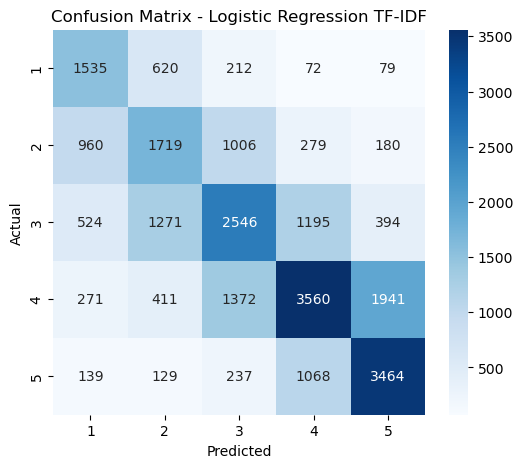

In [208]:
# 5. Predictions & Evaluation

y_pred = lr.predict(X_test_tfidf)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(df['Rating'].unique()),
            yticklabels=sorted(df['Rating'].unique()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression TF-IDF")
plt.show()

In [258]:
# Your new sample text
new_text = ['wrost product']

# Step 1 & 2: Vectorize the input text
X_new = tfidf.transform(new_text)

# Step 3: Predict with the logistic regression model
prediction = lr.predict(X_new)

print(prediction)


[1]
